In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

### 1.  Bộ dữ liệu ARE Historical Data

In [41]:
df1 = pd.read_csv('ARE-Historical-Data.csv')
df1

,Date,Price,Open,High,Low,Vol.,Change %
0,1/2/2015,89.79,89.11,89.88,88.54,277.62K,1.18%
1,1/5/2015,90.87,89.31,91.17,89.15,359.76K,1.20%
2,1/6/2015,91.33,90.65,91.56,90.25,1.33M,0.51%
3,1/7/2015,92.57,91.55,92.57,90.69,543.40K,1.36%
4,1/8/2015,93.63,92.57,93.85,92.43,718.78K,1.15%
...,...,...,...,...,...,...,...
2124,6/12/2023,121.00,120.28,121.71,120.03,788.83K,0.34%
2125,6/13/2023,122.06,121.15,123.93,120.50,846.11K,0.88%
2126,6/14/2023,121.92,122.99,123.79,120.83,1.01M,-0.11%
2127,6/15/2023,121.15,121.16,121.78,119.87,931.08K,-0.63%


In [42]:
df1 = df1[['Price']]
df1 = df1.dropna() # Drop missing values
df1

,Price
0,89.79
1,90.87
2,91.33
3,92.57
4,93.63
...,...
2124,121.00
2125,122.06
2126,121.92
2127,121.15


In [43]:
df1.isnull().sum()

Price    0
dtype: int64

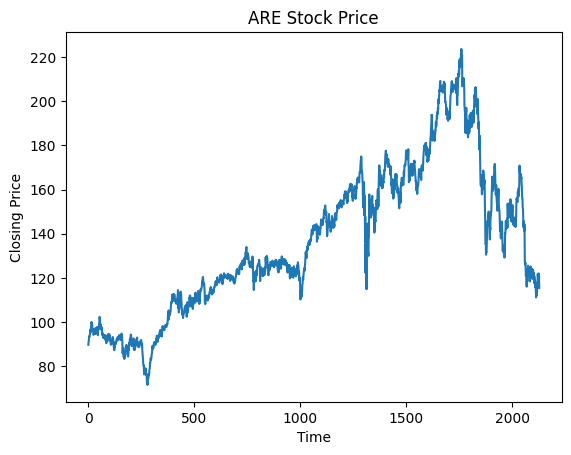

In [44]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('ARE Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

* Nhìn vào biểu đồ, chúng ta có thể thấy rằng giá đóng cửa của ARE có xu hướng tăng theo thời gian, nhưng đồng thời cũng có những biến động và dao động lớn. Điều này cho thấy dữ liệu không ổn định và có thể cần được xử lý trước khi sử dụng trong mô hình Holt-Winters.

In [45]:
# Sử dụng ADF (Augmented Dickey-Fuller) test để kiểm tra tính ổn định của dữ liệu
from statsmodels.tsa.stattools import adfuller
result = adfuller(df1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.630539
p-value: 0.467209
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


* Kết quả cho thấy p-value > 0.05 => dữ liệu không ổn định

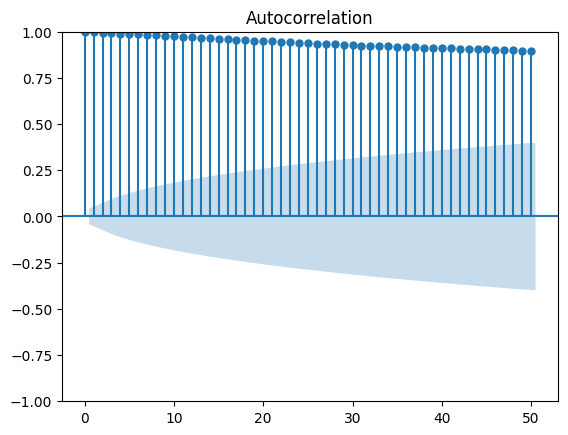

In [46]:
#Kiểm tra tính chu kỳ của dữ liệu
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df1, lags=50)
plt.show()

* Nhìn đồ thị ta thấy dữ liệu không có tính chu kỳ rõ ràng

Vậy dữ liệu ARE Historical Data ban đầu không phù hợp cho mô hình Holt-winters

In [47]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [48]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the model
model = ExponentialSmoothing(train_data, seasonal_periods=30, trend='add', seasonal='add').fit()

In [49]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.forecast(len(x_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.forecast(len(x_val))

In [50]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df1.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.forecast(len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1490    167.798078
1491    167.740174
1492    167.778557
1493    167.792568
1494    168.197595
1495    168.438536
1496    168.757563
1497    168.793153
1498    168.354437
1499    168.281137
1500    168.087654
1501    168.011667
1502    168.318090
1503    168.636212
1504    168.718705
1505    169.106541
1506    169.131738
1507    168.842129
1508    169.308558
1509    169.055225
1510    169.227306
1511    169.241124
1512    169.242044
1513    169.092962
1514    169.012451
1515    169.155614
1516    168.787956
1517    169.156974
1518    168.950376
1519    169.030591
dtype: float64


In [51]:
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 37.52301187621706
Testing RMSE: 21.37316213878339
Testing MAE: 16.771138201814423
Validation MAE: 32.75920646806812
Testing MAPE: 9.345946088906967
Validation MAPE: 25.128622556358753


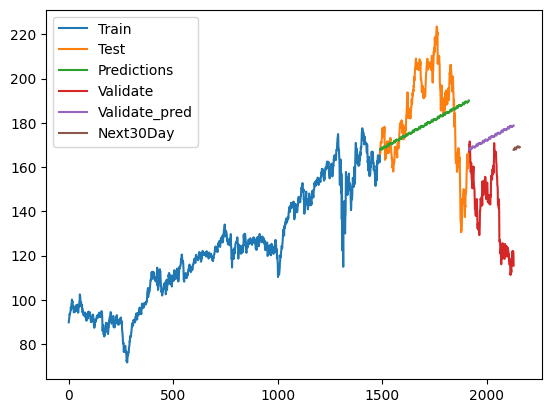

In [52]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate', 'Validate_pred','Next30Day'])
plt.show()

### 2.  Bộ dữ liệu ARI Historical Data

In [53]:
df2 = pd.read_csv('ARI-Historical-Data.csv')
df2

,Date,Price,Open,High,Low,Vol.,Change %
0,1/2/2015,16.54,16.49,16.55,16.35,184.56K,1.10%
1,1/5/2015,16.51,16.47,16.63,16.45,387.43K,-0.18%
2,1/6/2015,16.42,16.60,16.64,16.37,225.81K,-0.55%
3,1/7/2015,16.63,16.48,16.65,16.44,492.81K,1.28%
4,1/8/2015,16.49,16.69,16.69,16.45,440.70K,-0.84%
...,...,...,...,...,...,...,...
2124,6/12/2023,11.09,10.83,11.11,10.83,754.88K,2.21%
2125,6/13/2023,11.22,11.12,11.25,11.08,799.04K,1.17%
2126,6/14/2023,11.19,11.27,11.38,11.09,876.19K,-0.27%
2127,6/15/2023,11.42,11.15,11.44,11.14,1.07M,2.06%


In [77]:
df2 = df2[['Price']]
df2 = df2.dropna() # Drop missing values
df2

,Price
0,76.15
1,75.86
2,77.18
3,78.14
4,78.34
...,...
2124,152.73
2125,153.68
2126,153.40
2127,154.17


In [55]:
df2.isnull().sum()

Price    0
dtype: int64

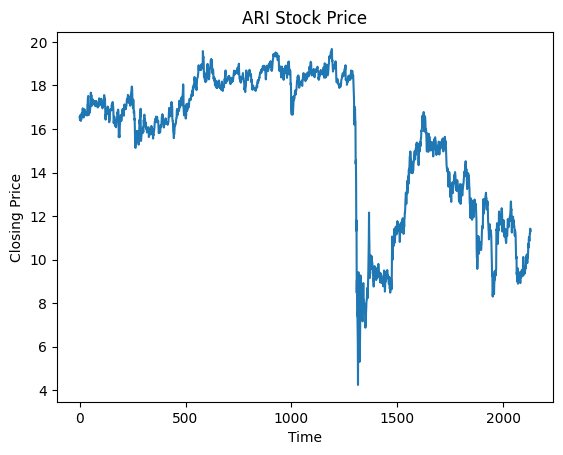

In [56]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df2)
plt.title('ARI Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

* Nhìn vào biểu đồ, chúng ta có thể thấy rằng giá đóng cửa của ARE có xu hướng tăng theo thời gian, nhưng đồng thời cũng có những biến động và dao động lớn. Điều này cho thấy dữ liệu không ổn định và có thể cần được xử lý trước khi sử dụng trong mô hình Holt-Winters.

In [57]:
# Sử dụng ADF (Augmented Dickey-Fuller) test để kiểm tra tính ổn định của dữ liệu
from statsmodels.tsa.stattools import adfuller
result = adfuller(df2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.708179
p-value: 0.426903
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


* Kết quả cho thấy p-value > 0.05 => dữ liệu không ổn định

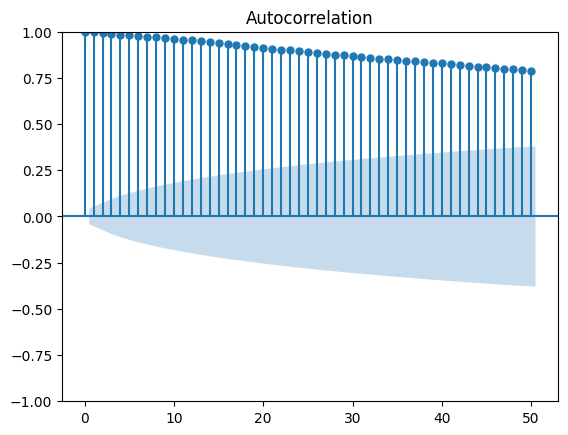

In [58]:
#Kiểm tra tính chu kỳ của dữ liệu
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df2, lags=50)
plt.show()

* Nhìn đồ thị ta thấy dữ liệu không có tính chu kỳ rõ ràng

Vậy dữ liệu ARE Historical Data ban đầu không phù hợp cho mô hình Holt-winters

In [59]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df2))
test_size = int(0.2 * len(df2))
val_size = len(df2) - train_size - test_size

train_data = df2[:train_size]
test_data = df2[train_size:train_size+test_size]
val_data = df2[train_size+test_size:]

In [60]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the model
model = ExponentialSmoothing(train_data, seasonal_periods=30, trend='add', seasonal='add').fit()

In [61]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.forecast(len(x_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.forecast(len(x_val))

In [62]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df2.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.forecast(len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1490    11.025527
1491    11.042667
1492    11.016753
1493    11.025344
1494    11.000446
1495    11.113285
1496    11.103298
1497    11.124932
1498    11.048611
1499    11.075938
1500    11.071655
1501    11.036675
1502    11.064060
1503    11.071275
1504    11.102092
1505    11.140677
1506    11.130078
1507    11.138459
1508    11.154855
1509    11.135262
1510    11.135077
1511    11.130270
1512    11.164873
1513    11.134264
1514    11.121681
1515    11.124091
1516    11.084883
1517    11.063078
1518    10.985281
1519    10.950678
dtype: float64


In [63]:
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 1.1181774717066564
Testing RMSE: 3.6701623234636656
Testing MAE: 3.327477148580106
Validation MAE: 0.9559589117458773
Testing MAPE: 23.29817771354149
Validation MAPE: 9.141457772714359


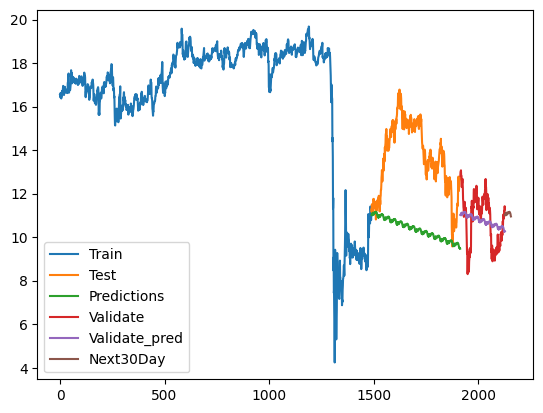

In [64]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate', 'Validate_pred','Next30Day'])
plt.show()

### 3.  Bộ dữ liệu MAA Historical Data

In [65]:
df2 = pd.read_csv('MAA-Historical-Data.csv')
df2

,Date,Price,Open,High,Low,Vol.,Change %
0,1/2/2015,76.15,74.47,76.19,74.47,276.36K,1.97%
1,1/5/2015,75.86,75.86,76.34,75.43,549.69K,-0.38%
2,1/6/2015,77.18,76.28,77.83,76.27,833.74K,1.74%
3,1/7/2015,78.14,76.48,78.34,76.29,544.77K,1.24%
4,1/8/2015,78.34,78.14,78.46,77.36,544.03K,0.26%
...,...,...,...,...,...,...,...
2124,6/12/2023,152.73,153.97,153.97,151.50,489.48K,-1.00%
2125,6/13/2023,153.68,151.82,153.78,151.28,513.48K,0.62%
2126,6/14/2023,153.40,154.35,155.11,152.47,388.42K,-0.18%
2127,6/15/2023,154.17,153.20,154.92,152.00,549.30K,0.50%


In [66]:
df2 = df2[['Price']]
df2 = df2.dropna() # Drop missing values
df2

,Price
0,76.15
1,75.86
2,77.18
3,78.14
4,78.34
...,...
2124,152.73
2125,153.68
2126,153.40
2127,154.17


In [67]:
df2.isnull().sum()

Price    0
dtype: int64

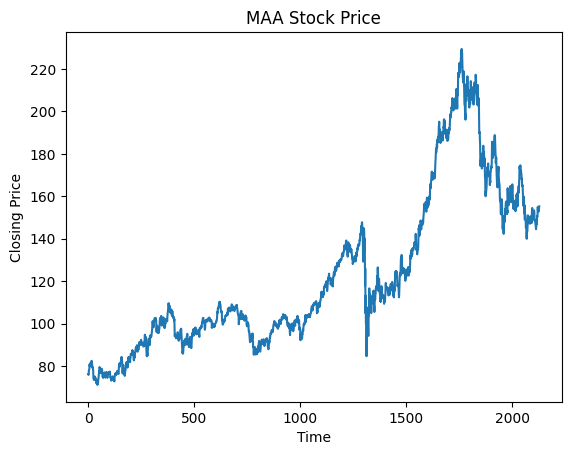

In [68]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df2)
plt.title('MAA Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

* Nhìn vào biểu đồ, chúng ta có thể thấy rằng giá đóng cửa của ARE có xu hướng tăng theo thời gian, nhưng đồng thời cũng có những biến động và dao động lớn. Điều này cho thấy dữ liệu không ổn định và có thể cần được xử lý trước khi sử dụng trong mô hình Holt-Winters.

In [69]:
# Sử dụng ADF (Augmented Dickey-Fuller) test để kiểm tra tính ổn định của dữ liệu
from statsmodels.tsa.stattools import adfuller
result = adfuller(df2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.227941
p-value: 0.661462
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


* Kết quả cho thấy p-value > 0.05 => dữ liệu không ổn định

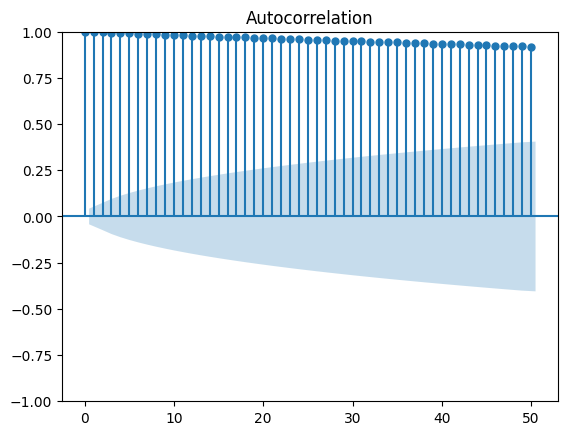

In [70]:
#Kiểm tra tính chu kỳ của dữ liệu
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df2, lags=50)
plt.show()

* Nhìn đồ thị ta thấy dữ liệu không có tính chu kỳ rõ ràng

Vậy dữ liệu ARE Historical Data ban đầu không phù hợp cho mô hình Holt-winters

In [71]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df2))
test_size = int(0.2 * len(df2))
val_size = len(df2) - train_size - test_size

train_data = df2[:train_size]
test_data = df2[train_size:train_size+test_size]
val_data = df2[train_size+test_size:]

In [72]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the model
model = ExponentialSmoothing(train_data, seasonal_periods=30, trend='add', seasonal='add').fit()

In [73]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.forecast(len(x_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.forecast(len(x_val))

In [74]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df2.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.forecast(len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1490    124.492272
1491    124.455684
1492    124.182006
1493    124.344411
1494    124.447780
1495    124.775746
1496    124.914464
1497    125.018701
1498    124.642657
1499    124.817551
1500    124.835999
1501    124.836967
1502    125.215759
1503    125.474935
1504    125.502173
1505    125.650430
1506    125.583826
1507    125.337533
1508    125.882823
1509    125.851962
1510    125.982504
1511    125.939130
1512    125.956852
1513    126.094513
1514    126.146589
1515    126.338725
1516    125.888420
1517    126.148237
1518    125.779892
1519    125.657574
dtype: float64


In [75]:
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 31.29842712432981
Testing RMSE: 53.01696203331047
Testing MAE: 46.3003765549104
Validation MAE: 29.27145146489755
Testing MAPE: 24.205403530422114
Validation MAPE: 18.231953027725016


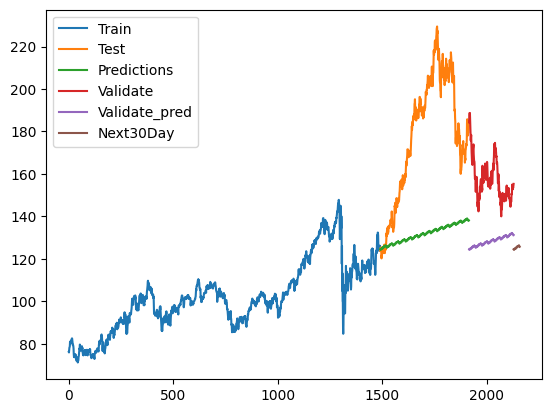

In [76]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate', 'Validate_pred','Next30Day'])
plt.show()